In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import gaussian_filter, generic_filter
import os

In [17]:
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    # Calculate local mean and standard deviation for each pixel
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))

    # Define threshold based on local statistics
    threshold = local_mean + threshold_factor * local_std

    # Identify bad pixels based on thresholding
    bad_pixel_mask = image_data > threshold

    # Get coordinates of bad pixels
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)

    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

In [20]:
def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    # Read FITS file
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    #.data.astype(np.int32)
    hdul.close()

    # Count and locate bad pixels
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, 
                                                                                   threshold_factor, neighborhood_size)

    print(f"Number of bad pixels in {fits_filename}:", num_bad_pixels)
    print(f"Coordinates of bad pixels in {fits_filename}:", bad_pixel_coords)

    # Plot the original image with bad pixels marked
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')
    plt.scatter(bad_pixel_coords[:, 1], bad_pixel_coords[:, 0], color='red', s=1, label='Bad Pixels')
#     plt.colorbar(label='Pixel Value')
    plt.title(f'Bad Pixels in {fits_filename}')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.legend()
    plt.show()

    # Calculate spatial noise using window method
    noise_image = generic_filter(image_data, np.std, size=window_size)

    # Plot the noise image
    plt.figure(figsize=(10, 8))
    plt.imshow(noise_image, cmap='viridis', origin='lower')
    plt.colorbar(label='Noise (Standard Deviation)')
    plt.title(f'Noise image for {fits_filename}')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.show()
    
    # Histogram of pixel values
    plt.figure(figsize=(10, 8))
    plt.hist(image_data.flatten(), bins=100, color='blue', alpha=0.7)
    plt.title(f'Pixel Value Distribution for {fits_filename}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

    # Histogram of spatial noise
    plt.figure(figsize=(10, 8))
    plt.hist(noise_image.flatten(), bins=100, color='green', alpha=0.7)
    plt.title(f'Spatial Noise Distribution for {fits_filename}')
    plt.xlabel('Noise (Standard Deviation)')
    plt.ylabel('Frequency')
    plt.show()
    return noise_image, num_bad_pixels, bad_pixel_coords, bad_pixel_mask

Testing with threshold factor: 50
Number of bad pixels in 10ramp_1c_1g_1read_1reset/H2RG_Slow_FullWin_20241210_000001.fits: 763
Coordinates of bad pixels in 10ramp_1c_1g_1read_1reset/H2RG_Slow_FullWin_20241210_000001.fits: [[   5  553]
 [   5 1382]
 [   6  352]
 ...
 [2039   49]
 [2042   49]
 [2043  678]]


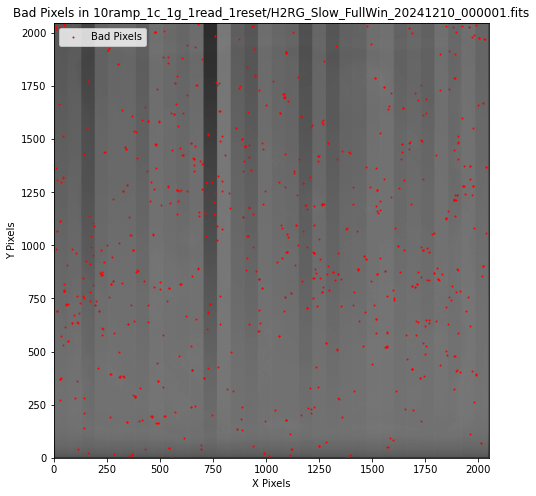

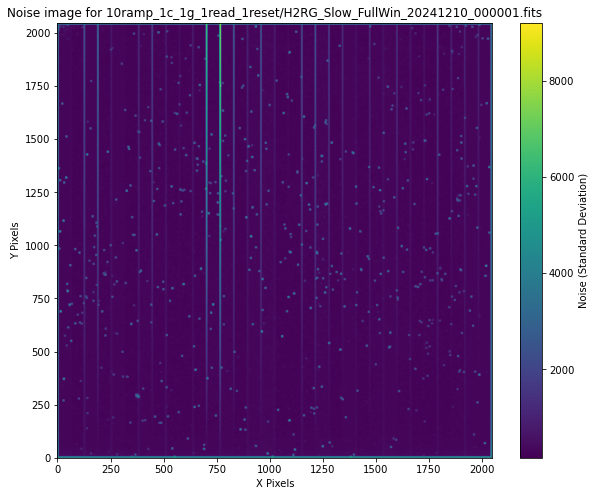

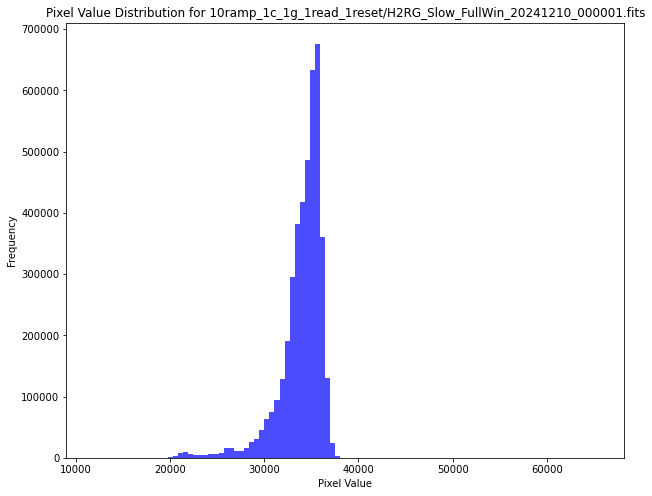

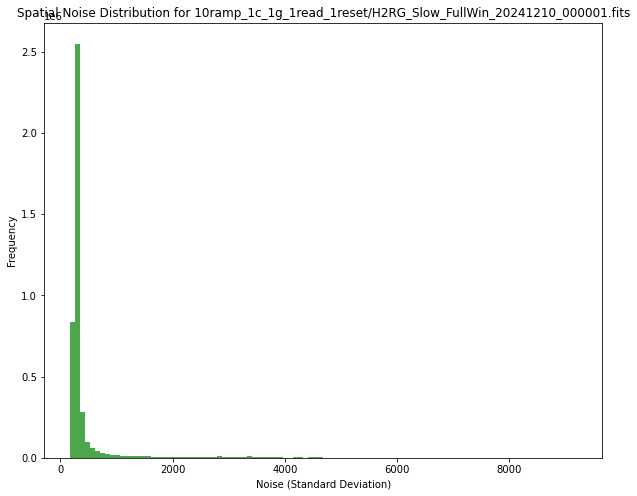

Noise image array shape: (2048, 2048)


In [23]:
# Define parameters
# Define a range of threshold factors to test
threshold_factors = [50]
neighborhood_size = 80  # Adjust this size
window_size = 10  # Adjust this size

# Process each image in the folder
fits_filenames = ["10ramp_1c_1g_1read_1reset/H2RG_Slow_FullWin_20241210_000001.fits"]

for factor in threshold_factors:
    print(f"Testing with threshold factor: {factor}")
    for fits_filename in fits_filenames:
        # Call the function once and capture the returned noise_image
        noise_image, num_bad_pixels, bad_pixel_coords, bad_pixel_mask = process_image(
            fits_filename, factor, neighborhood_size, window_size
        )
        print(f"Noise image array shape: {noise_image.shape}")

NameError: name 'noise_image' is not defined

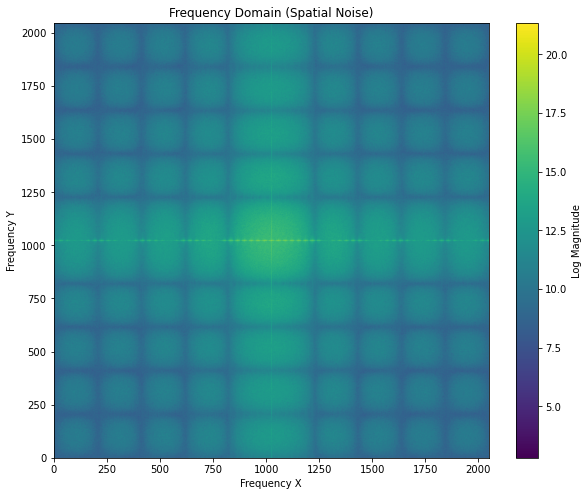

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def frequency_analysis_spatial(noise_image):
    # Compute 2D FFT of the noise image
    fft_image = np.fft.fft2(noise_image)
    fft_shifted = np.fft.fftshift(fft_image)  # center the zero-frequency component

    # Compute the magnitude spectrum
    magnitude_spectrum = np.log1p(np.abs(fft_shifted))

    # Plot the magnitude spectrum
    plt.figure(figsize=(10, 8))
    plt.imshow(magnitude_spectrum, origin='lower', cmap='viridis')
    plt.colorbar(label='Log Magnitude')
    plt.title('Frequency Domain (Spatial Noise)')
    plt.xlabel('Frequency X')
    plt.ylabel('Frequency Y')
    plt.show()

# Example usage
frequency_analysis_spatial(noise_image)

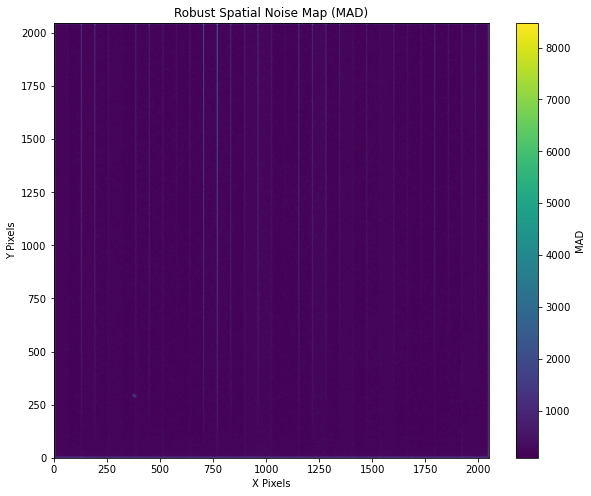

In [26]:
# Read FITS file
hdul = fits.open(fits_filename)
image_data = hdul[0].data
#.data.astype(np.int32)
hdul.close()
def mad_filter(data):
    median_val = np.median(data)
    return np.median(np.abs(data - median_val))

# Apply MAD filter over a window to get a robust spatial noise map
def robust_spatial_noise(image_data, window_size):
    # window_size: int or tuple representing the filter size
    robust_noise = generic_filter(image_data, mad_filter, size=window_size)
    return robust_noise

# Example usage
robust_noise_map = robust_spatial_noise(image_data, window_size=10)
plt.figure(figsize=(10,8))
plt.imshow(robust_noise_map, origin='lower', cmap='viridis')
plt.colorbar(label='MAD')
plt.title('Robust Spatial Noise Map (MAD)')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

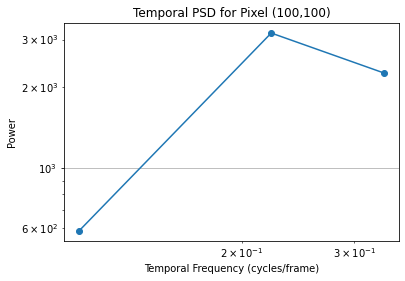

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def compute_temporal_psd(stacked_images, pixel_coord=(100, 100)):
    """
    Compute the temporal PSD for a single pixel.
    stacked_images: np.array of shape (frames, height, width)
    pixel_coord: (y, x) coordinates of the pixel
    """
    y, x = pixel_coord
    pixel_time_series = stacked_images[:, y, x]

    # Detrend if desired (optional)
    pixel_time_series = pixel_time_series - np.mean(pixel_time_series)

    # Compute FFT
    fft_values = np.fft.fft(pixel_time_series)
    psd = np.abs(fft_values)**2

    # Frequencies
    n_frames = len(pixel_time_series)
    freqs = np.fft.fftfreq(n_frames)  # in cycles per frame

    return freqs[1:n_frames//2], psd[1:n_frames//2]  # Skip the DC and use half spectrum

# Example usage:
fits_filenames = [f'10ramp_1c_1g_1read_1reset/H2RG_Slow_FullWin_20241210_{str(i).zfill(6)}.fits' 
                  for i in range(1, 10)]
image_data_list = []
for fname in fits_filenames:
    with fits.open(fname) as hdul:
        image_data_list.append(hdul[0].data.astype(np.int32))
stacked_images = np.stack(image_data_list, axis=0)

freqs, psd = compute_temporal_psd(stacked_images, pixel_coord=(100, 100))

plt.figure()
plt.loglog(freqs, psd, marker='o')
plt.xlabel('Temporal Frequency (cycles/frame)')
plt.ylabel('Power')
plt.title('Temporal PSD for Pixel (100,100)')
plt.grid(True)
plt.show()


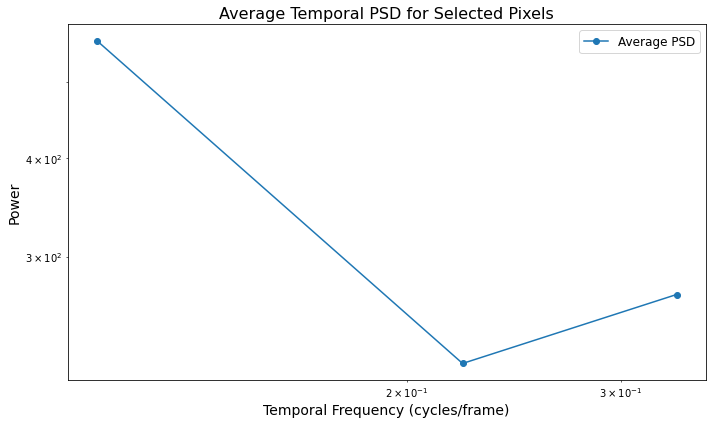

In [21]:
def compute_temporal_psd(stacked_images, pixel_coords):
    """
    Compute the temporal PSD for multiple pixels and return the average PSD.
    stacked_images: np.array of shape (frames, height, width)
    pixel_coords: List of (y, x) coordinates of the pixels to analyze
    """
    n_frames = stacked_images.shape[0]
    psds = []
    
    for coord in pixel_coords:
        y, x = coord
        pixel_time_series = stacked_images[:, y, x]

        # Detrend the time series (optional)
        pixel_time_series = pixel_time_series - np.mean(pixel_time_series)

        # Compute FFT and PSD
        fft_values = np.fft.fft(pixel_time_series)
        psd = np.abs(fft_values)**2 / n_frames  # Normalize by the number of frames
        psds.append(psd[1:n_frames//2])  # Skip DC component

    # Average PSD across the selected pixels
    avg_psd = np.mean(psds, axis=0)
    freqs = np.fft.fftfreq(n_frames)[1:n_frames//2]
    
    return freqs, avg_psd

# Select multiple pixel coordinates for averaging
pixel_coords = [(100, 100), (512,512),(1000,1000), (2000,2000)]  # Example pixels
freqs, avg_psd = compute_temporal_psd(stacked_images, pixel_coords)

# Plot the Temporal PSD
plt.figure(figsize=(10, 6))
plt.loglog(freqs, avg_psd, marker='o', label='Average PSD')
plt.xlabel('Temporal Frequency (cycles/frame)', fontsize=14)
plt.ylabel('Power', fontsize=14)
plt.title('Average Temporal PSD for Selected Pixels', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [22]:
from scipy.stats import linregress

def compute_drift(stacked_images, pixel_coord=(100, 100)):
    y, x = pixel_coord
    pixel_time_series = stacked_images[:, y, x]
    t = np.arange(len(pixel_time_series))

    # Fit a linear trend
    slope, intercept, r_value, p_value, std_err = linregress(t, pixel_time_series)

    # Compute detrended series
    detrended = pixel_time_series - (slope*t + intercept)

    return slope, intercept, detrended

slope, intercept, detrended_series = compute_drift(stacked_images)
print("Pixel drift slope:", slope, "ADU/frame")


Pixel drift slope: -0.45000000000000007 ADU/frame


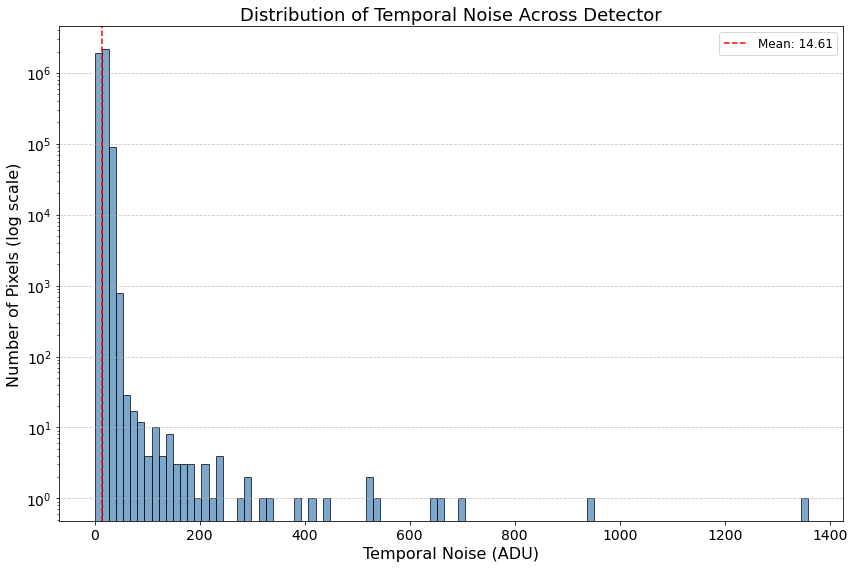

In [27]:
# Compute summary statistics
mean_noise = np.mean(temporal_noise)
median_noise = np.median(temporal_noise)
percentile_90 = np.percentile(temporal_noise, 90)

# Plot the histogram with annotations
plt.figure(figsize=(12, 8))
plt.hist(temporal_noise.flatten(), bins=100, log=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_noise, color='red', linestyle='--', label=f'Mean: {mean_noise:.2f}')
# plt.axvline(median_noise, color='green', linestyle='--', label=f'Median: {median_noise:.2f}')
# plt.axvline(percentile_90, color='orange', linestyle='--', label=f'90th Percentile: {percentile_90:.2f}')
plt.xlabel('Temporal Noise (ADU)', fontsize=16)
plt.ylabel('Number of Pixels (log scale)', fontsize=16)
plt.title('Distribution of Temporal Noise Across Detector', fontsize=18)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase font size for tick labels
plt.tight_layout()
plt.savefig('temporal_noise_dist.png', dpi=300, bbox_inches='tight')
plt.show()


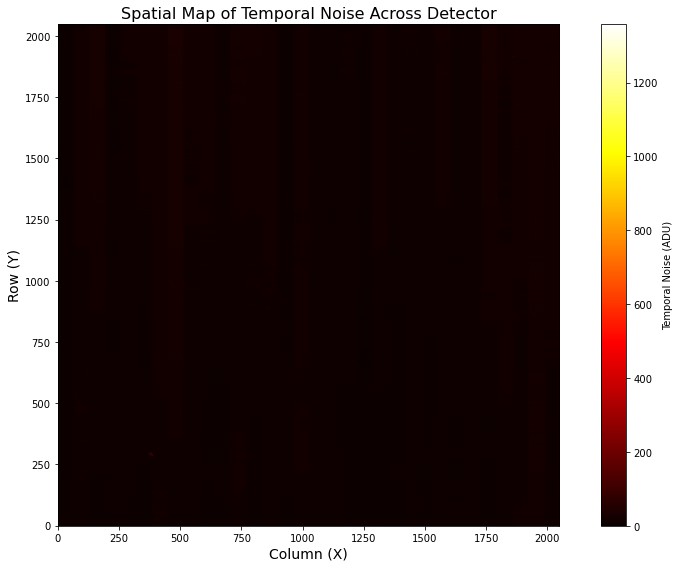

In [8]:
plt.figure(figsize=(12, 8))
plt.imshow(temporal_noise, cmap='hot', origin='lower')
plt.colorbar(label='Temporal Noise (ADU)')
plt.title('Spatial Map of Temporal Noise Across Detector', fontsize=16)
plt.xlabel('Column (X)', fontsize=14)
plt.ylabel('Row (Y)', fontsize=14)
plt.tight_layout()
plt.show()


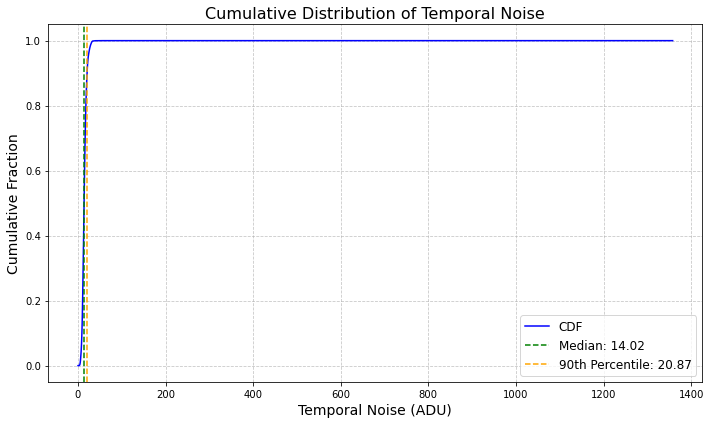

In [16]:
sorted_noise = np.sort(temporal_noise.flatten())
cdf = np.cumsum(np.ones_like(sorted_noise)) / len(sorted_noise)

plt.figure(figsize=(10, 6))
plt.plot(sorted_noise, cdf, label='CDF', color='blue')
plt.axvline(median_noise, color='green', linestyle='--', label=f'Median: {median_noise:.2f}')
plt.axvline(percentile_90, color='orange', linestyle='--', label=f'90th Percentile: {percentile_90:.2f}')
plt.xlabel('Temporal Noise (ADU)', fontsize=14)
plt.ylabel('Cumulative Fraction', fontsize=14)
plt.title('Cumulative Distribution of Temporal Noise', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


8484.16861486435 8993.0
8715.941547393799 9231.0


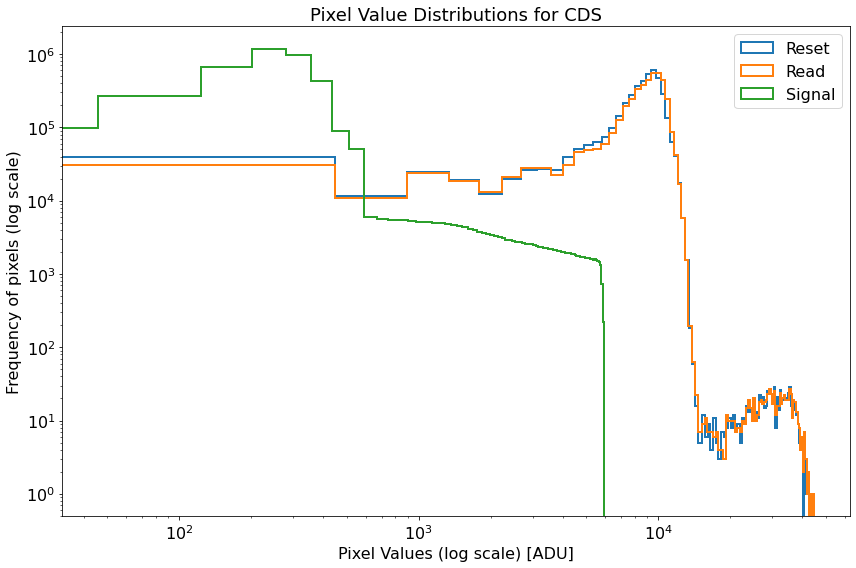

In [11]:
def read_fits(file):
    with fits.open(file) as hdul:
        data = hdul[0].data
    return data

number_of_files = 2  

fits_files = [f'cds/Frame_R01_M01_N0{i+1}.fits' for i in range(number_of_files)]
fig,ax=plt.subplots(figsize=(12,8))
labels = ['Reset', 'Read']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i,f in enumerate(fits_files):
    data = read_fits(f)
    ax.hist(data.flatten(),bins=100,histtype='step',  linewidth=2, label=labels[i], color=colors[i]);
    print (np.mean(data),np.median(data))
diff = read_fits(f'cds/CDSResult.fits')
ax.hist(diff.flatten(),bins=100,histtype='step',  linewidth=2, label='Signal', color=colors[2]);
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Pixel Values (log scale) [ADU]', fontsize=16)
ax.set_ylabel('Frequency of pixels (log scale)', fontsize=16)
ax.set_title('Pixel Value Distributions for CDS', fontsize=18)
ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig('cds.png', dpi=300, bbox_inches='tight')
plt.show()

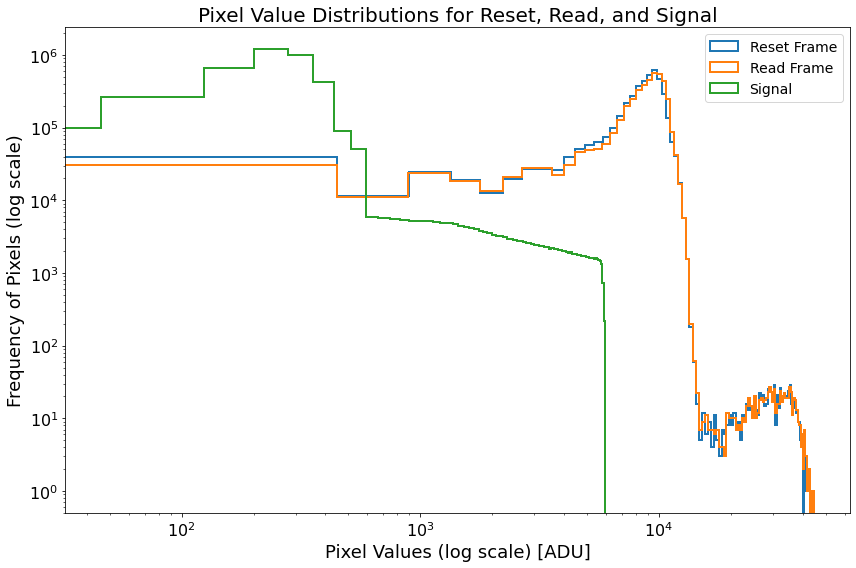

In [9]:
def read_fits(file):
    """
    Read FITS file and extract data.
    """
    with fits.open(file) as hdul:
        data = hdul[0].data
    return data

# Files and labels
number_of_files = 2
fits_files = [f'cds/Frame_R01_M01_N0{i+1}.fits' for i in range(number_of_files)]
labels = ['Reset Frame', 'Read Frame', 'Signal']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct, easily distinguishable colors (blue, orange, green)

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through Reset and Read frames
for i, f in enumerate(fits_files):
    data = read_fits(f)
    ax.hist(data.flatten(), bins=100, histtype='step', linewidth=2, label=labels[i], color=colors[i])

# Add CDS (Signal)
signal_data = read_fits(f'cds/CDSResult.fits')
ax.hist(signal_data.flatten(), bins=100, histtype='step', linewidth=2, label=labels[2], color=colors[2])

# Customize the plot
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Pixel Values (log scale) [ADU]', fontsize=18)
ax.set_ylabel('Frequency of Pixels (log scale)', fontsize=18)
ax.set_title('Pixel Value Distributions for Reset, Read, and Signal', fontsize=20)
ax.legend(fontsize=14, loc='upper right')

# Adjust layout and show
plt.tight_layout()
plt.show()


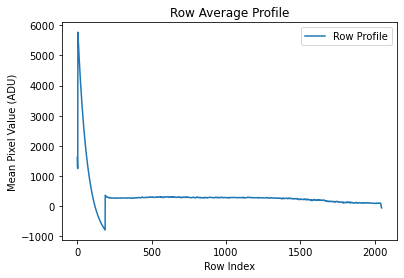

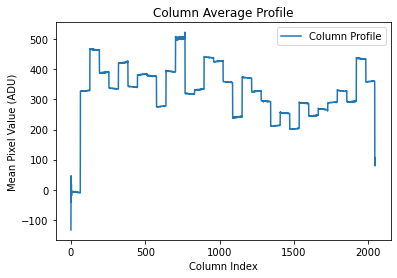

In [5]:
cds_file = f'cds/CDSResult.fits'
with fits.open(cds_file) as hdul1:
    cds_data = hdul1[0].data
row_profile = np.mean(cds_data, axis=1)  # average each row
col_profile = np.mean(cds_data, axis=0)  # average each column

plt.figure()
plt.plot(row_profile, label='Row Profile')
plt.legend()
plt.xlabel('Row Index')
plt.ylabel('Mean Pixel Value (ADU)')
plt.title('Row Average Profile')
plt.show()

plt.figure()
plt.plot(col_profile, label='Column Profile')
plt.legend()
plt.xlabel('Column Index')
plt.ylabel('Mean Pixel Value (ADU)')
plt.title('Column Average Profile')
plt.show()


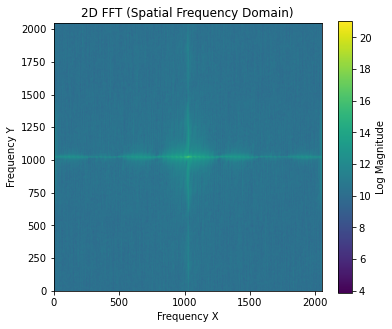

In [6]:
def spatial_fft(image):
    fft_image = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_image)
    magnitude_spectrum = np.log1p(np.abs(fft_shifted))
    return magnitude_spectrum

magnitude_spectrum = spatial_fft(cds_data)

plt.figure(figsize=(6,5))
plt.imshow(magnitude_spectrum, cmap='viridis', origin='lower')
plt.colorbar(label='Log Magnitude')
plt.title("2D FFT (Spatial Frequency Domain)")
plt.xlabel("Frequency X")
plt.ylabel("Frequency Y")
plt.show()


In [ ]:


def load_frame(filename):
    with fits.open(filename) as hdul:
        data = hdul[0].data.astype(np.float32)
    return data

# 1. Load your four frames (two ramps, each with two reads)
r1a = load_frame("cds_noise/Frame_R01_M01_N01.fits")
r1b = load_frame("cds_noise/Frame_R01_M01_N02.fits")
r2a = load_frame("cds_noise/Frame_R02_M01_N01.fits")
r2b = load_frame("cds_noise/Frame_R02_M01_N02.fits")

# 2. Compute two CDS images
CDS_1 = r1b - r1a
CDS_2 = r2b - r2a

# 3. Compute the difference (Spatial CDS Noise)
noise_frame = CDS_2 - CDS_1

###############################################################################
# (A) Basic Statistics & Histogram
###############################################################################
mean_val = np.mean(noise_frame)
std_val = np.std(noise_frame)

print("Noise Frame Mean:", mean_val)
print("Noise Frame Std Dev:", std_val)

plt.figure(figsize=(6,5))
plt.hist(noise_frame.flatten(), bins=100, log=True)
plt.title("Histogram of Spatial CDS Noise")
plt.xlabel("Pixel Value (ADU)")
plt.ylabel("Count (log scale)")
plt.show()

###############################################################################
# (B) 2D Visualization
###############################################################################
plt.figure(figsize=(8,6))
plt.imshow(noise_frame, origin='lower', cmap='bwr', vmin=-3*std_val, vmax=3*std_val)
plt.colorbar(label='Noise (ADU)')
plt.title("Spatial CDS Noise Frame")
plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.show()

###############################################################################
# (C) Row/Column Profiles
###############################################################################
row_profile = np.mean(noise_frame, axis=1)
col_profile = np.mean(noise_frame, axis=0)

plt.figure()
plt.plot(row_profile)
plt.title("Row Average of Noise Frame")
plt.xlabel("Row Index")
plt.ylabel("Mean Pixel Value (ADU)")
plt.show()

plt.figure()
plt.plot(col_profile)
plt.title("Column Average of Noise Frame")
plt.xlabel("Column Index")
plt.ylabel("Mean Pixel Value (ADU)")
plt.show()

###############################################################################
# (D) 2D FFT for Noise Frame
###############################################################################
def compute_2d_fft(image):
    fft_image = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_image)
    magnitude_spectrum = np.log1p(np.abs(fft_shifted))
    return magnitude_spectrum

noise_fft = compute_2d_fft(noise_frame)

plt.figure(figsize=(6,5))
plt.imshow(noise_fft, origin='lower', cmap='inferno')
plt.colorbar(label='Log Magnitude')
plt.title("2D FFT of CDS Noise Frame")
plt.xlabel("Frequency X")
plt.ylabel("Frequency Y")
plt.show()
